In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from keras.datasets import mnist
from sklearn import datasets
from sklearn.model_selection import train_test_split
from numba import jit, njit, types, vectorize
from numba.extending import overload, register_jitable
from numba.core.errors import TypingError

ModuleNotFoundError: No module named 'numba'

### Data generation

In [ ]:
full = False

In [ ]:
if full:
    (train_X, train_y), (test_X, test_y) = mnist.load_data()
    train_X = train_X.reshape(-1,784).astype(np.float64)
    test_X = test_X.reshape(-1,784).astype(np.float64)

In [ ]:
if not full:
    digits = datasets.load_digits()
    train_X, test_X, train_y, test_y = train_test_split(digits.data, digits.target, test_size=0.1, random_state=4)
    train_X = train_X.reshape(-1,64).astype(np.float64)
    test_X = test_X.reshape(-1,64).astype(np.float64)

In [ ]:
samples = train_X.shape[0]
x_dim = train_X.shape[1]
X = train_X.T

In [ ]:
dgt = 0
class_1 = X[:,train_y != dgt]
class_2 = X[:,train_y == dgt]
mu_1 = np.mean(class_1, axis=1)
mu_2 = np.mean(class_2, axis=1)
Sigma = np.cov(class_1)

In [43]:
Y = np.zeros((2, samples))

for k in range(samples):
    Y[1, k] = 1 if train_y[k] == 0 else 0

### Optimal solution

In [44]:
w_opt = np.linalg.pinv(Sigma)@(mu_1-mu_2)
w_opt = w_opt/np.sqrt(w_opt.T@(Sigma)@w_opt)

In [45]:
obj_opt = (w_opt.T@(mu_1-mu_2))**2

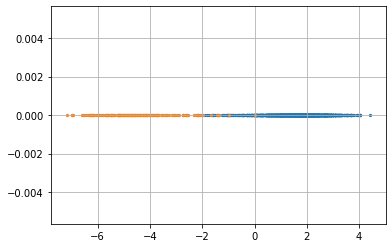

In [46]:
plt.scatter(w_opt.T@class_1,np.zeros((w_opt.T@class_1).shape),s=5)
plt.scatter(w_opt.T@class_2,np.zeros((w_opt.T@class_2).shape),s=5)
plt.grid()
plt.show()

In [47]:
(np.sum(w_opt.T@class_1 > 1/2 * w_opt.T@(mu_1+mu_2))  + np.sum(w_opt.T@class_2 < 1/2 * w_opt.T@(mu_1+mu_2)))/samples

0.9901051329622759

### Offline algorithm

In [48]:
# eta = 1e-3; gam = 1e2*eta; iters = 10000000

In [49]:
# obj = np.zeros(iters)
# err = np.zeros(iters)
# acc = np.zeros(iters)

# @jit(nopython=True)
# def fit(w, l, mu_1, mu_2, Sigma):
#     w = w + eta*(mu_1 - mu_2 - l*Sigma@w)
#     l = l + gam*((w.T@Sigma@w).item() - 1)
    
#     return w, l
        
# def run_offline(mu_1, mu_2, Sigma, eta, gamma, iters):
    
#     w = np.random.randn(x_dim)/np.sqrt(x_dim)
#     l = 1
    
#     for i_iter in tqdm(range(iters)):
#         w, l = fit(w, l, mu_1, mu_2, Sigma)
#         obj[i_iter] = (w.T@(mu_1-mu_2))**2/(w.T@Sigma@w)
#         err[i_iter] = np.linalg.norm(w - w_opt)**2
#         acc[i_iter] = (np.sum(w.T@class_1 > 1/2 * w.T@(mu_1+mu_2))  + np.sum(w.T@class_2 < 1/2 * w.T@(mu_1+mu_2)))/samples
#         #err[i_iter] = (obj_opt - obj[i_iter])/obj_opt
#     return w,l

# w,l = run_offline(mu_1, mu_2, Sigma, eta, gam, iters)

In [50]:
# plt.loglog(range(iters), err)
# plt.ylabel("Error")
# plt.xlabel("t")
# plt.title("Offline convergence")
# plt.show()
# plt.loglog(range(iters), acc)
# plt.ylabel("Accuracy")
# plt.xlabel("t")
# plt.title("Offline convergence")
# plt.show()

In [51]:
# (np.sum(w.T@class_1 > 1/2 * w.T@(mu_1+mu_2))  + np.sum(w.T@class_2 < 1/2 * w.T@(mu_1+mu_2)))/samples

### Online algorithm

In [52]:

@njit
def eta(t):
    return e/t

@njit
def fit_bio(w, l, mu, x, y, zeta, l_, c,  t, step):
    r = w.T@x
    
    if y[1] == 0:
        mu += (x - mu)/t
        zeta += (r-zeta)/t
        c += (r-c)/(2*t)
        w += step*(mu - l*(r-zeta)*(x-mu))
        l += gam*step*((r-zeta)**2 - 1)
        l_ += 1
        
    else:
        c += (l_*r - c)/(2*t)
        w -= step*l_*x
        l_ = 1
        
    z = r - c  
    return w, l, r, c, mu, zeta, l_

@njit
def run_bio(w, l, c, zeta, l_, mu, X, Y, err, acc, start_epoch, end_epoch):

    for i_epoch in range(start_epoch, end_epoch):

        idx = np.random.permutation(samples)
        
        for i_sample in range(samples):

            i_iter = i_epoch*samples + i_sample
            t = i_iter + 1

            x = X[:,idx[i_sample]]
            y = Y[:,idx[i_sample]]
            step = eta(t)
            
            w, l, r, c, mu, zeta, l_ = fit_bio(w, l, mu, x, y, zeta, l_, c, t, step)

            err[i_iter] = np.linalg.norm(w - w_opt)**2
            acc[i_iter] = acc[i_iter-1] * (t-1)
            if (y[1] == 0 and r > c) or (y[1] == 1 and r < c):  
                acc[i_iter] += 1
            acc[i_iter] = acc[i_iter]/t
    return w, l, c, zeta, l_, mu, err, acc

In [54]:
for i in range(1):
    e = 1e-5; gam = 1e2;  epochs = int(1e3); total_epochs = 200 * epochs; iters = total_epochs*samples
    w = np.random.randn(x_dim)/np.sqrt(x_dim)
    l = 1
    c = 0
    zeta = 0
    l_ = 1
    mu = np.zeros(x_dim)
    err = np.zeros(iters)
    acc = np.zeros(iters)
    for itr in tqdm(range(0,total_epochs, epochs)):
#         print(itr, itr+epochs)
        w, l, c, zeta, l_, mu, err, acc = run_bio(w, l, c, zeta, l_, mu, X, Y, err, acc, itr, itr+epochs)

        print(f"itr: {itr}, err: {err[(itr+1)*samples-1]}, acc:{acc[(itr+1)*samples-1]}")
       

  0%|▏                                          | 1/200 [00:02<07:47,  2.35s/it]

itr: 0, err: 7.472706887518596, acc:0.16141001855287604


  1%|▍                                          | 2/200 [00:04<07:53,  2.39s/it]

itr: 1000, err: 7.472373677505728, acc:0.13128491792684152


  2%|▊                                          | 4/200 [00:09<07:49,  2.39s/it]

itr: 2000, err: 7.4723401396498215, acc:0.13119599754851644
itr: 3000, err: 7.472320501969699, acc:0.131166337668907


  3%|█▎                                         | 6/200 [00:14<07:51,  2.43s/it]

itr: 4000, err: 7.47230656549073, acc:0.13115150402255718
itr: 5000, err: 7.47229575904052, acc:0.1311426026483017


  4%|█▋                                         | 8/200 [00:19<07:52,  2.46s/it]

itr: 6000, err: 7.472286925146849, acc:0.13113666790434858
itr: 7000, err: 7.472279451826076, acc:0.13113242855934232


  4%|█▉                                         | 9/200 [00:21<07:50,  2.46s/it]

itr: 8000, err: 7.472272979573589, acc:0.13112924891811115


  6%|██▎                                       | 11/200 [00:27<08:07,  2.58s/it]

itr: 9000, err: 7.472267269957271, acc:0.13112677578531176
itr: 10000, err: 7.472262160494798, acc:0.13112479722962994


  6%|██▌                                       | 12/200 [00:30<08:20,  2.66s/it]

itr: 11000, err: 7.472257536661742, acc:0.13112317837863297


  6%|██▋                                       | 13/200 [00:33<08:30,  2.73s/it]

itr: 12000, err: 7.472253318973831, acc:0.13112182931364436
itr: 13000, err: 7.472249436156699, acc:0.1311206877811662

  8%|███▏                                      | 15/200 [00:38<08:34,  2.78s/it]


itr: 14000, err: 7.4722458413439865, acc:0.13111970931310135


  8%|███▎                                      | 16/200 [00:44<08:30,  2.77s/it]

itr: 15000, err: 7.472242494759323, acc:0.13111886129875114


SystemError: CPUDispatcher(<function run_bio at 0x165637680>) returned a result with an error set

In [ ]:
plt.loglog(err)
plt.show()

In [ ]:
def add_fill_lines(axis, t, err, plot_kwargs=None, ci_kwargs=None):
    """
    Parameters:
    ====================
    axis        -- Axis variable
    t           -- Array of time points
    err         -- The data matrix of errors over multiple trials
    plot_kwargs -- Arguments for axis.plot()
    ci_kwargs   -- Arguments for axis.fill_between()
    
    Output:
    ====================
    plot        -- Function axis.plot()
    fill        -- Function axis.fill_between() with standard deviation computed on a log scale
    """
        
    log_err = np.log(err+10**-5) # add 10**-5 to ensure the logarithm is well defined
    log_mu = log_err.mean(axis=0)
    sigma = np.std(log_err,axis=0)
    ci_lo, ci_hi = log_mu - sigma, log_mu + sigma
    plot_kwargs = plot_kwargs or {}
    ci_kwargs = ci_kwargs or {}
    plot = axis.loglog(t, np.exp(log_mu), **plot_kwargs)
    fill = axis.fill_between(t, np.exp(ci_lo), np.exp(ci_hi), alpha=.1, **ci_kwargs)
    
    return plot, fill

In [ ]:
from matplotlib import gridspec
plt.figure(figsize=(20, 12))
gs = gridspec.GridSpec(2,2)


ax1 = plt.subplot(gs[0,0])

add_fill_lines(ax1, range(iters), err[None])
plt.title("Online convergence")
plt.ylabel("Error")
plt.xlabel("Sample #")
plt.xlim(1e2,iters)
plt.grid()
plt.show()

/Users/aneeshkashalikar/.pyenv/versions/3.7.10/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  if sys.path[0] == '':


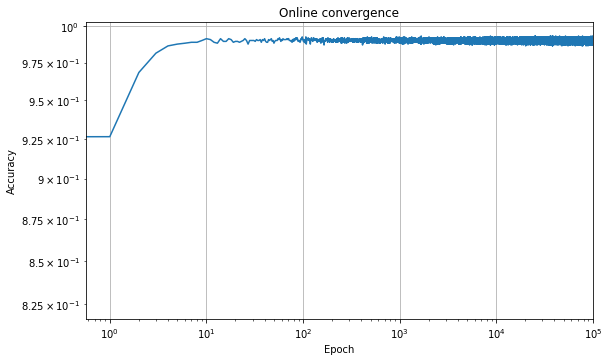

In [40]:
from matplotlib import gridspec
plt.figure(figsize=(20, 12))
gs = gridspec.GridSpec(2,2)


ax1 = plt.subplot(gs[0,0])

add_fill_lines(ax1, range(epochs), acc[None])
plt.title("Online convergence")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.xlim(0,epochs)
plt.grid()
plt.show()